In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

# Importing Libraries


In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import tensorflow as tf

# Loading and Preprocessing the Data

In [3]:
images_path = '/kaggle/input/face-mask-detection/images'
annotations_path = '/kaggle/input/face-mask-detection/annotations'

In [4]:
images = []
labels = []

images_files = os.listdir(images_path)

In [5]:
for image_file in images_files:
    # Load Image
    image_path = os.path.join(images_path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Load corresponding annotation
    annotation_file = os.path.join(annotations_path, os.path.splitext(image_file)[0] + '.xml')
    
    if os.path.exists(annotation_file): 
        tree = ET.parse(annotation_file)
        root = tree.getroot()
        
        # Iterate over each object in the annotation file
        for obj in root.findall('object'):
            label = obj.find('name').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            
            # Crop the region of interest (face)
            face = image[ymin:ymax, xmin:xmax]
            face = cv2.resize(face, (224, 224)) # Resize to fit the model
            
            # Append image and label
            images.append(face)
            labels.append(1 if label == 'with_mask' else 0)
            
# Convert to NumPy arrays
images = np.array(images) / 255.0  # Normalize images
labels = np.array(labels)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


# Splitting the Data

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

# Building the Model

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Loading the MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False,
                        input_shape=(224, 224, 3))

# Freeze the Base Model Layers
base_model.trainable = False

# Builing the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Compiling the model

In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), 
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# Training the model

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10


I0000 00:00:1727722998.219986      69 service.cc:145] XLA service 0x7e3974114ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727722998.220032      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727722998.220036      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/102 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.2135 - loss: 2.0590

I0000 00:00:1727723005.684156      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


102/102 ━━━━━━━━━━━━━━━━━━━━ 28s 159ms/step - accuracy: 0.6451 - loss: 0.8503 - val_accuracy: 0.8160 - val_loss: 0.3909
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8098 - loss: 0.4396 - val_accuracy: 0.8307 - val_loss: 0.3533
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8378 - loss: 0.3649 - val_accuracy: 0.8356 - val_loss: 0.3421
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8521 - loss: 0.3329 - val_accuracy: 0.8663 - val_loss: 0.3165
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8663 - loss: 0.3215 - val_accuracy: 0.8724 - val_loss: 0.3107
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8775 - loss: 0.2985 - val_accuracy: 0.8761 - val_loss: 0.2951
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8824 - loss: 0.2679 - val_accuracy: 0.8761 - val_loss: 0.2869
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8980 - loss: 0.2558 - val_accuracy: 0.8

# Evaluating the Model

In [10]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8989 - loss: 0.2600
Test Accuracy: 88.71%


# Visualising Training Results

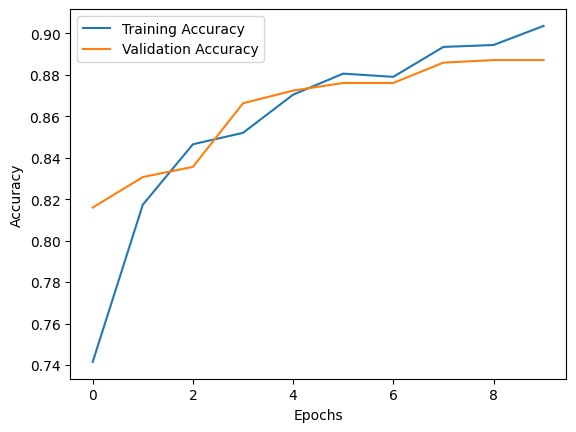

In [11]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predictions

26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step


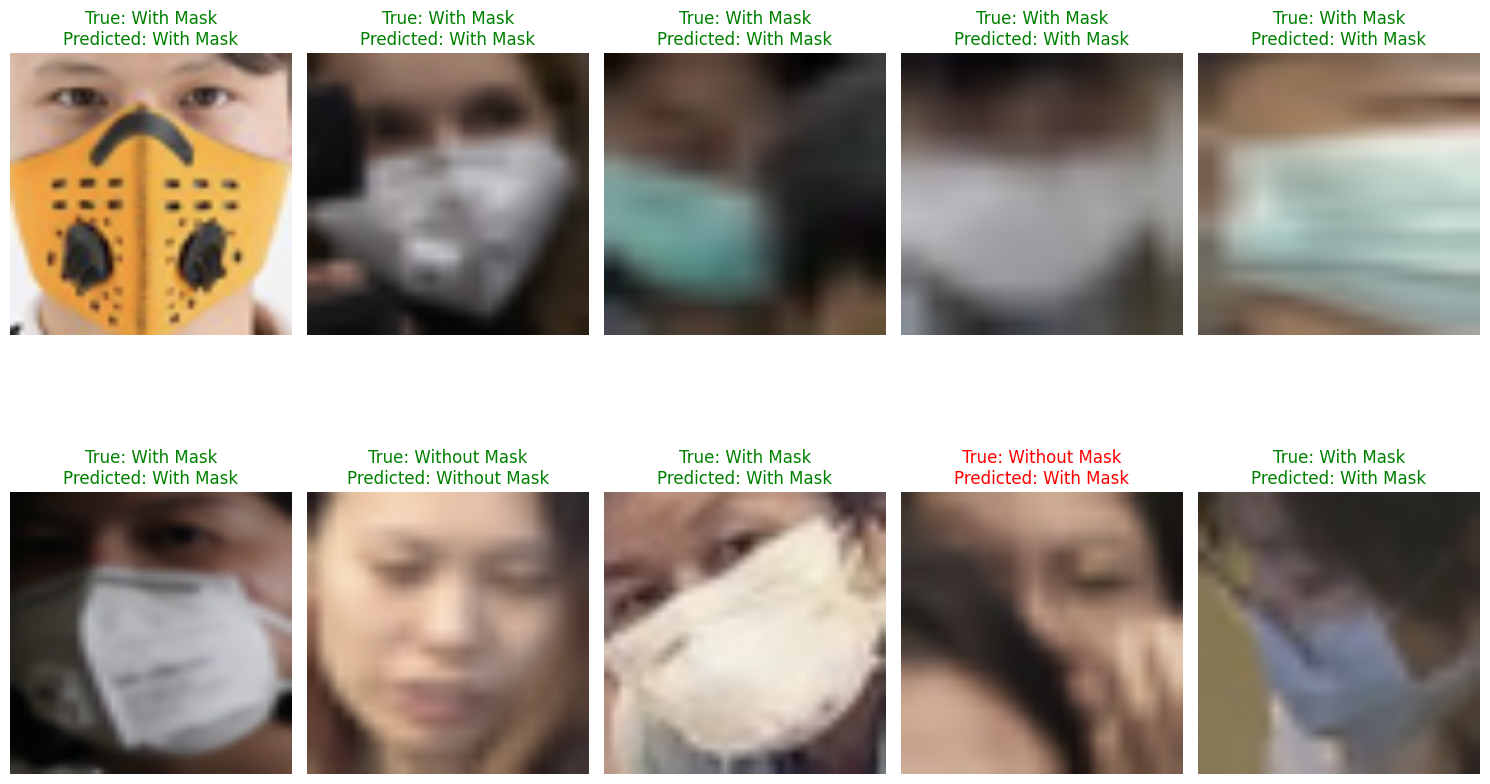

In [12]:
import matplotlib.pyplot as plt

# Get model predictions for the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Map label indices to actual label names
label_map = {0: "Without Mask", 1: "With Mask"}

# Display a few test images along with their predicted and true labels
num_images_to_display = 10  # Adjust the number of images you want to visualize
plt.figure(figsize=(15, 10))

for i in range(num_images_to_display):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[i])
    plt.axis('off')
    true_label = label_map[true_labels[i]]
    predicted_label = label_map[predicted_labels[i]]
    color = "green" if true_labels[i] == predicted_labels[i] else "red"
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

plt.tight_layout()
plt.show()
